In [26]:
import time
from itertools  import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from joblib import Parallel,delayed
import warnings
warnings.filterwarnings('ignore')
from warnings import catch_warnings,filterwarnings   # catch_warnings暂时禁止警告，filterwarnings在警告过滤器中插入一条数据项。默认情况下，该数据项将被插到前面；
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#传入数据和参数，输出模型预测
def model_forecast(history,config):
    order, sorder, trend = config
    model = SARIMAX(history,order=order,seasonal_order=sorder,trend=trend,enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)   # disp如果为True则会打印收敛信息
    # statsmodels.tsa.statespace.sarimax.SARIMAX.fit
    yhat = model_fit.predict(len(history), len(history))   # 获取样本内拟合值的最后一个值
    # statsmodels.tsa.statespace.sarimax.SARIMAXResults.predict
    # 模型结果有四个方法获取值，predict、get_predict、forecast、get_forecast
    # predict(start,end)、get_predict：样本内预测值，拟合值； 其中的参数start和end的意思是：获取拟合值的范围，默认是获取所有拟合值；当然也可以通过设置end来获取样本外预测值
    # forecast(step)、get_forecast：样本外预测值，拟合值； 其中step为预测的周期数，如step=2，则得到接下来两个周期的预测值
    return yhat[0]

In [3]:
#模型评估指标,mape
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    

#划分训练集和测试集
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


In [4]:
#one-step滚动向前预测
def forward_valid(data, n_test, cfg):
    predictions = list()   # 得到空列表
    # 调用数据集划分函数train_test_split
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        # 调用预测函数model_forecast
        yhat = model_forecast(history, cfg)
        # 接收预测结果
        predictions.append(yhat)
        # 用测试数据不断扩充训练数据（这里为什么不用预测数据扩充）
        history.append(test[i])
    # 调用评估函数mape，看效果
    error = mape(test, predictions)
    return error


In [5]:
#模型评估
def score_model(data,n_test,cfg,debug=False):
    result = None
    key = str(cfg)
    if debug:
        # 调用滚动预测函数forward_valid
        result = forward_valid(data, n_test, cfg)
    else:
        try:
            # catch_warnings暂时禁止警告，filterwarnings在警告过滤器中插入一条数据项。默认情况下，该数据项将被插到前面；
            with catch_warnings():
                filterwarnings("ignore")
                # 调用滚动预测函数forward_valid
                result = forward_valid(data, n_test, cfg)
        except:
            error = None
            
    return (key, result)


In [6]:
#网格搜索
def grid_search(data, cfg_list, n_test, parallel=True):
    # parallel=True这个参数的意义是：由用户选择是否启用多进程。
    scores = None
    if parallel:
        # 使用计算机全部的cpu核数多进程并行
        # Joblib提供了一个简单的帮助类来编写并行化的循环。其核心思想是把代码写成生成器表达式的样子，然会再将它转换为并行计算
        executor = Parallel(n_jobs=4, backend='multiprocessing')   # 使用所有cpu创建进程池
        # 调用score_model函数，将参数列表中的参数循环，然后与数据一起调用函数
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)   # 调用score_model函数，并传参(data, n_test, cfg)
        # 启动多进程
        scores = executor(tasks)
        ## Parallel(n_jobs=-1)(delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 也可以一步到位
        
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda x: x[1])   # sort和lambda的联合使用，scores现在是列表，列表内是多个元组，这里针对元组的第二个值进行升序排序
    return scores

#生成参数列表
def sarima_configs(seasonal=[0]):   
    p = d = q = [0,1,2]
    # product(A,B)函数,返回A和B中的元素组成的笛卡尔积的元组,
    pdq = list(product(p, d, q))   
    s = 32
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]
    t=['n','c','t','ct']
    return list(product(pdq,seasonal_pdq,t))

In [7]:
#模型训练
def train_model(sale_df):
    n_test = 3
    p_b,d_b,q_b=[],[],[]
    P_b,D_b,Q_b=[],[],[]
    m_b,t_b=[],[]
    model_id,error=[],[]
    for i in sale_df['store_code'].unique():
        data=sale_df[sale_df['store_code']==i]['y']
        data=[i for i in data]
        # 调用sarima_configs函数————> 返回多个参数多个值的组合列表
        cfg_list = sarima_configs()
        # 调用grid_search函数————> 返回一个列表，列表内是多个元组，元组第一个值是参数组合，第二个值是参数的mape得分，根据得分进行了升序排序，
        scores = grid_search(data,cfg_list,n_test,parallel=True)
        # 解析出每个分店的最优参数组合，并放入Dataframe中进行返回
        p_b.append(int(scores[0][0][2]))
        d_b.append(int(scores[0][0][5]))
        q_b.append(int(scores[0][0][8]))
        P_b.append(int(scores[0][0][13]))
        D_b.append(int(scores[0][0][16]))
        Q_b.append(int(scores[0][0][19]))
        m_b.append(int(scores[0][0][22]))
        t_b.append(str(scores[0][0][27]))
        model_id.append(i)
        error.append(scores[1][-1])
        params_df=pd.DataFrame({'store_code': model_id, 'map': error,'p':p_b,'d':d_b,'q':q_b,'P':P_b,'D':D_b,'Q':Q_b,'m':m_b,'t':t_b})
    return params_df


In [8]:
#定义预测函数，传入数据和参数，返回预测值
def one_step_forecast(data,order,seasonal_order,t,h_fore):
    predictions=list()
    data=[i for i in data]
    for i in range(h_fore):
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order,trend=t,enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        yhat = model_fit.predict(len(data), len(data))
        data.append(yhat[0])
        predictions.append(yhat[0])
    return predictions


#用for循环，多个序列预测
def forecast_model(sale_df,params_df):
    h_fore=4   # 预测的步数，将会用来作为循环次数，每次循环都把预测的最近的一步作为训练数据的追加数据
    fore_list=[]
    model_id=[]
    for i in sale_df['store_code'].unique():
        #params_list=params_df[params_df['store_code']==i]
        # 读取每个分店的最优参数
        data=sale_df[sale_df['store_code']==i]['y']
        p=params_df[params_df['store_code']==i].iloc[:,2].values[0]
        d=params_df[params_df['store_code']==i].iloc[:,3].values[0]
        q=params_df[params_df['store_code']==i].iloc[:,4].values[0]
        P=params_df[params_df['store_code']==i].iloc[:,5].values[0]
        D=params_df[params_df['store_code']==i].iloc[:,6].values[0]
        Q=params_df[params_df['store_code']==i].iloc[:,7].values[0]
        m=params_df[params_df['store_code']==i].iloc[:,8].values[0]
        t=params_df[params_df['store_code']==i].iloc[:,9].values[0]
        order=(p, d, q)
        seasonal_order=(P,D,Q,m)
        # 调用one_step_forecast函数————> 拟合h_fore次数，返回4次拟合的结果列表
        all_fore=one_step_forecast(data,order,seasonal_order,t,h_fore)
        fore_list.append(all_fore)
        
        #以下为，多步预测，如果不使用滚动预测，则不调one_step_forecast函数
        #model=SARIMAX(data, order=order,seasonal_order=seasonal_order,trend=t,enforce_stationarity=False,
        #                                                enforce_invertibility=False)
        #forecast_=model.fit(disp=-1).forecast(steps=h_fore)
        #fore_list_flatten = [x for x in forecast_]
        #fore_list.append(fore_list_flatten)
        model_id.append(i)
    df_forecast = pd.DataFrame({'store_code': model_id, 'fore': fore_list})
    return df_forecast


In [17]:
def pretreatment(all_data):
    all_data = all_data[~(all_data['numbers']==1)]
    all_data['year'] = all_data['date'].map(lambda x: x.split('-')[0])
    all_data['mon_day'] = all_data['date'].map(lambda x: x[5:])

    everYear_min_date, everYear_max_date = [], []
    for k in all_data['year'].unique():
        i_data = all_data[all_data['year']==k]
        everYear_min_date.append(min(i_data['mon_day']))
        everYear_max_date.append(max(i_data['mon_day']))

    all_data = all_data[(all_data['mon_day']>=max(everYear_min_date)) & (all_data['mon_day']<=min(everYear_max_date))]
    all_data.set_index('date',inplace=True)

    # all_data.rename({'numbers': 'y'},axis='columns',inplace=True)
    all_data.insert(all_data.shape[1], 'store_code', 1)
    
    return all_data

In [10]:
if __name__ == '__main__':
    start_time=time.time()
    all_data = pd.read_csv('./num_predict.csv')
    all_data = pretreatment(all_data)
    # sale_df=pd.read_excel('/home/test01/store_forecast/sale_df.xlsx')
    # 调用train_model函数————> 返回最优参数组合
    params_df=train_model(all_data)
    # 调用forecast_model函数————> 返回每个分店对应的4个预测值（样本内的拟合值）
    forecast_out=forecast_model(all_data,params_df)
    end_time=time.time()
    use_time=(end_time-start_time)//60
    print('finish the process use',use_time,'mins')

Process SpawnPoolWorker-2:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-1:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/site-packages/joblib/pool.py", line 147, in get
    return recv()
Traceback (most recent call last):
  File "/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python

KeyboardInterrupt: 

## 直接给定参数预测

In [18]:
all_data = pd.read_csv('./num_predict.csv')
all_data = pretreatment(all_data)

# 2016-2020的数据
data_2016_2020 = list(all_data[~(all_data['year']=='2021')]['numbers'].values)
data_2d_2016_2020 = all_data[~(all_data['year']=='2021')]
# 2021的数据
data_2021 = list(all_data[all_data['year']=='2021']['numbers'].values)
# 全部数据
all_data_list = list(all_data['numbers'].values)

,numbers,year,mon_day,store_code
date,,,,
2016-09-06,22.0,2016,09-06,1
2016-09-07,26.0,2016,09-07,1
2016-09-08,29.0,2016,09-08,1
2016-09-09,24.0,2016,09-09,1
2016-09-10,35.0,2016,09-10,1
...,...,...,...,...
2021-10-03,65.0,2021,10-03,1
2021-10-04,55.0,2021,10-04,1
2021-10-05,65.0,2021,10-05,1


In [22]:
fore_list = one_step_forecast(data_2016_2020,(3,0,3),(2,2,0,32),'t', 3)

/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ayd/opt/anaconda3/envs/pythonLoadVenv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
fore_list

[18.237302199794424, 22.065092089707843, 15.896631164469117]

In [24]:
data_2021[:3]

[50.0, 49.0, 50.0]

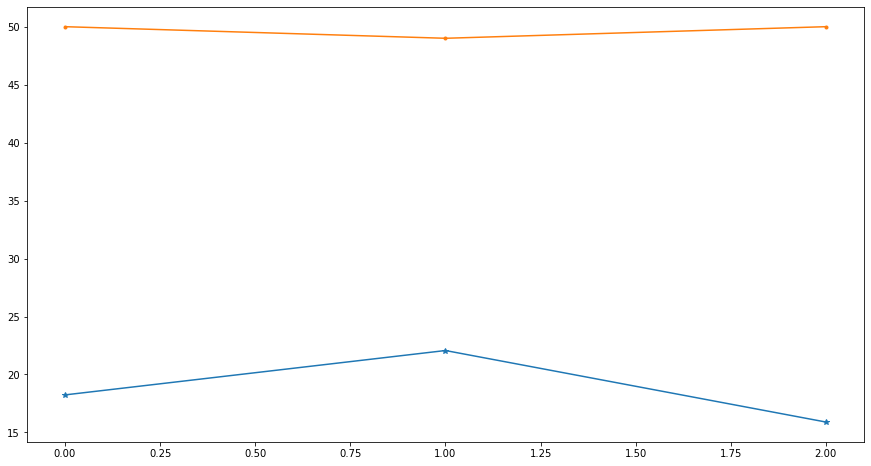

In [27]:

plt.figure(figsize=(15, 8))
l3, = plt.plot(fore_list, marker='*')
l4, = plt.plot(data_2021[:3], marker='.')
plt.show()

In [28]:
def mape_fun(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape_fun(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def assess(predict_data):
    # 均方误差
    mse = metrics.mean_squared_error(data_2021, predict_data)
    print('均方误差MSE:', mse)
    # 均方根误差
    rmse = np.sqrt(metrics.mean_squared_error(data_2021, predict_data))
    print('均方根误差RMSE:', rmse)
    # 平均绝对误差
    mae = metrics.mean_absolute_error(data_2021, predict_data)
    print('平均绝对误差MAE:', mae)
    # 平均绝对百分比误差
    mape = mape_fun(data_2021, predict_data)
    print('平均绝对百分比误差MAPE:', mape)
    # 对称平均绝对百分比误差
    smape = smape_fun(data_2021, predict_data)
    print('对称平均绝对百分比误差SMAPE:', smape)

In [ ]:
assess(fore_list)